In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn import preprocessing, model_selection
from sklearn.metrics import f1_score, confusion_matrix, classification_report

from transformers import BertModel, BertTokenizer

from tqdm import tqdm
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
from transformers import AutoModel, AutoTokenizer
import transformers

import time
import matplotlib.pyplot as plt

In [2]:
NUM_EPOCHS = 3
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 8
TEST_SIZE = 0.2

In [3]:
# path = '../data/restaurants_laptop_train_with_pos_task2.csv'
# MODEL_PATH = "model.task2.no_clean.bin"
path = '../data/restaurants_laptop_train_with_pos_task2_cleaned.csv'
MODEL_PATH = "model.task2.cleaned.bin"

df = pd.read_csv(path)
aspect_df = df[df.aspect_tag == "AT"]
polarity_unique_values = aspect_df.polarity.unique()

# df = df[:200]

# replace all -1 to 2 since pytorch cannot handle negative
# so, 2 now means negative polarity
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

# polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 3


0

In [4]:
df

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,1,0
1,s_1,charge,VERB,1,0
2,s_1,it,PRON,1,0
3,s_1,at,ADP,1,0
4,s_1,night,NOUN,1,0
...,...,...,...,...,...
56572,s_3501,and,CCONJ,1,0
56573,s_3501,rice,NOUN,0,0
56574,s_3501,and,CCONJ,1,0
56575,s_3501,glass,NOUN,0,0


In [5]:
idx = 1
print(sentences[idx])
print(aspect_tags[idx])
print(polarity_tags[idx])

['However', 'the', 'multi', '-', 'touch', 'gestures', 'and', 'large', 'tracking', 'area', 'make', 'having', 'an', 'external', 'mouse', 'unnecessary', 'unless', 'you', "'re", 'gaming']
[1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0]
[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = to_device(v, device)
        return data
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:

device = get_default_device()
print(device)

NUM_POLARITY_TAGS = len(polarity_unique_values)

# tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

cuda


In [8]:
class SentenceTagDataset(Dataset):
    def __init__(self, tokenizer, sentences, aspect_tags, polarity_tags, aspect_term_tag, 
                 max_length=128):
        self.sentences = sentences
        self.aspect_tags = aspect_tags
        self.polarity_tags = polarity_tags
        self.aspect_term_tag = aspect_term_tag
        self.max_length = max_length
        self.special_token = -100

        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]  # Get a sentence
        aspect_tags = self.aspect_tags[idx]  # Get the corresponding aspect tags
        polarity_tags = self.polarity_tags[idx]

        sentence_encoding = self.tokenizer(
            sentence,
            is_split_into_words=True,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors="pt",
        )

        word_ids = sentence_encoding.word_ids(batch_index=0)
        polarity_tags_encoding = []
        previous_word_idx = None
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                polarity_tags_encoding.append(self.special_token)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                if aspect_tags[word_idx] == self.aspect_term_tag:
                    polarity_tags_encoding.append(polarity_tags[word_idx])
                else:
                    polarity_tags_encoding.append(self.special_token)
            else:
                polarity_tags_encoding.append(self.special_token)
            previous_word_idx = word_idx
        polarity_tags_encoding = torch.LongTensor(polarity_tags_encoding)

        return {
            "input_ids": sentence_encoding["input_ids"][0],
            "attention_mask": sentence_encoding["attention_mask"][0],
            "token_type_ids": sentence_encoding["token_type_ids"][0],
            "polarity_tags": polarity_tags_encoding,
        }
    


In [9]:
def loss_fn(output, target, mask, num_labels):
    cel = nn.CrossEntropyLoss()
    masking = mask.view(-1) == 1
    pred = output.view(-1, num_labels)
    true = torch.where(masking, target.view(-1), 
                       torch.tensor(cel.ignore_index).type_as(target))
    
    loss = cel(pred, true)
    return loss

class PolarityExtractionModel(nn.Module):
    def __init__(self, num_polarity_tags, num_vocab):
        super(PolarityExtractionModel, self).__init__()
        self.num_polarity_tags = num_polarity_tags
        self.bert_model = transformers.BertModel.from_pretrained("bert-base-cased")        
        self.dropout = nn.Dropout(0.3)
        # self.bert.config.hidden_size is 768
        self.fc = nn.Linear(self.bert_model.config.hidden_size, self.num_polarity_tags)
        # if the number of vocab has been increased, then need to add the new vector 
        # at the end of the embedding matrix
        self.bert_model.resize_token_embeddings(num_vocab)
                
    def forward(self, input_ids, attention_mask, token_type_ids, polarity_tags):
        out, _ = self.bert_model(input_ids, attention_mask = attention_mask, 
                                 token_type_ids = token_type_ids, return_dict=False)
        
        pol_out = self.dropout(out)
        pol_out = self.fc(pol_out)
        
        loss_pol = loss_fn(pol_out, polarity_tags, attention_mask, self.num_polarity_tags)
        
        s = nn.Softmax(dim=2)
        
        pol_out = s(pol_out)
        
        return pol_out, loss_pol

In [10]:
def cal_acc(pred_tags, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[true_tags!=-100]
    true_tags = true_tags[true_tags!=-100]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm



In [11]:
(train_sentences, test_sentences, 
 train_aspect_tags, test_aspect_tags, 
 train_polarity_tags, test_polarity_tags) = model_selection.train_test_split(
    sentences, aspect_tags, polarity_tags, random_state = 42, test_size = TEST_SIZE)

train_sentences.shape, test_sentences.shape, train_aspect_tags.shape, test_aspect_tags.shape, train_polarity_tags.shape, test_polarity_tags.shape

((2800,), (701,), (2800,), (701,), (2800,), (701,))

In [12]:
idx = 2
print(train_sentences[idx])
print(train_aspect_tags[idx])
print(train_polarity_tags[idx])

['I', 'had', 'it', 'months', 'when', 'my', 'disc', 'drive', 'refused', 'to', 'open']
[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0]


In [13]:
train_dataset = SentenceTagDataset(tokenizer=tokenizer, sentences=train_sentences, 
                                   aspect_tags=train_aspect_tags,
                                   polarity_tags=train_polarity_tags,
                                   aspect_term_tag=np.where(encoder.classes_ == "AT")[0].item())
train_data_loader = DeviceDataLoader(torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE), device)    

test_dataset = SentenceTagDataset(tokenizer=tokenizer, sentences=test_sentences, 
                                  aspect_tags=test_aspect_tags,
                                  polarity_tags=test_polarity_tags,
                                  aspect_term_tag=np.where(encoder.classes_ == "AT")[0].item())
test_data_loader = DeviceDataLoader(torch.utils.data.DataLoader(
    test_dataset, batch_size=TEST_BATCH_SIZE), device)   

model = to_device(PolarityExtractionModel(num_polarity_tags = NUM_POLARITY_TAGS,
                                          num_vocab = len(tokenizer)), device)

# print(model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
torch.cuda.empty_cache()

num_train_steps = int(len(train_sentences) / TRAIN_BATCH_SIZE * NUM_EPOCHS)
optimizer = AdamW(model.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=num_train_steps)

best_loss = np.inf

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []
    for data in tqdm(train_data_loader, total=len(train_data_loader)):
        
        optimizer.zero_grad()
        pred_polarity_tags, loss = model(**data)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_losses.append(loss.item())

        final_pred_polarity_tags.append(torch.argmax(pred_polarity_tags, dim=2))
        final_true_polarity_tags.append(data['polarity_tags'])
        
#         print(pred_polarity_tags)
#         print(data['polarity_tags'])

    polarity_train_acc, polarity_train_f1, polarity_train_cm = cal_acc(final_pred_polarity_tags, 
                                                                       final_true_polarity_tags)
        
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []
    for data in tqdm(test_data_loader, total=len(test_data_loader)):
        pred_polarity_tags, loss = model(**data)
        
        test_loss.append(loss.item())
        
        final_pred_polarity_tags.append(torch.argmax(pred_polarity_tags, dim=2))
        final_true_polarity_tags.append(data['polarity_tags'])

    polarity_test_acc, polarity_test_f1, polarity_test_cm = cal_acc(final_pred_polarity_tags, 
                                                                    final_true_polarity_tags)

    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_test_loss = sum(test_loss) / len(test_loss)
        
    print("Train Loss: {:.5f}; Valid Loss: {:.5f}".format(avg_train_loss, avg_test_loss))
    print("Polarity Train acc: {:.2f}%; Valid acc: {:.2f}%".format(
        polarity_train_acc*100, polarity_test_acc*100))
    print("Polarity Train f1: {:.2f}%; Valid f1: {:.2f}%".format(
        polarity_train_f1*100, polarity_test_f1*100))
    print("Polarity Train cm:\n {}".format(np.flip(polarity_train_cm)))
    print("Polarity Valid cm:\n {}".format(np.flip(polarity_test_cm)))
    
    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['valid_loss'].append(avg_test_loss)
    history['polarity_train_acc'].append(polarity_train_acc.cpu().numpy())
    history['polarity_valid_acc'].append(polarity_test_acc.cpu().numpy())
    

100%|██████████| 88/88 [00:04<00:00, 19.96it/s]


Train Loss: 0.80754; Valid Loss: 0.60772
Polarity Train acc: 63.18%; Valid acc: 75.10%
Polarity Train f1: 61.67%; Valid f1: 73.69%
Polarity Train cm:
 [[ 921  864   99]
 [ 326 3149  113]
 [ 337  743  189]]
Polarity Valid cm:
 [[358  73  27]
 [ 62 851  41]
 [105 138 136]]


100%|██████████| 88/88 [00:04<00:00, 19.61it/s]


Train Loss: 0.44945; Valid Loss: 0.63232
Polarity Train acc: 81.74%; Valid acc: 77.50%
Polarity Train f1: 81.73%; Valid f1: 78.00%
Polarity Train cm:
 [[1573  160  151]
 [ 163 3259  166]
 [ 311  280  678]]
Polarity Valid cm:
 [[356  45  57]
 [ 55 817  82]
 [ 73  91 215]]


100%|██████████| 88/88 [00:04<00:00, 19.30it/s]

Train Loss: 0.29077; Valid Loss: 0.64085
Polarity Train acc: 89.11%; Valid acc: 77.16%
Polarity Train f1: 89.20%; Valid f1: 77.16%
Polarity Train cm:
 [[1723   53  108]
 [  85 3388  115]
 [ 209  164  896]]
Polarity Valid cm:
 [[331  78  49]
 [ 39 856  59]
 [ 60 124 195]]


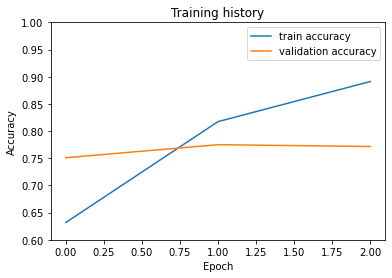

In [15]:
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.6, 1]);

In [16]:
def get_classification_report(test_data_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []
    with torch.no_grad():
        for data in tqdm(test_data_loader, total=len(test_data_loader)):
            pred_polarity_tags, loss = model(**data)
            
            final_pred_polarity_tags.extend(torch.argmax(pred_polarity_tags, dim=2))
            final_true_polarity_tags.extend(data['polarity_tags'])
            
    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
    
    # Remove the special -100 tokens 
    final_pred_polarity_tags = final_pred_polarity_tags[final_true_polarity_tags!=-100]
    final_true_polarity_tags = final_true_polarity_tags[final_true_polarity_tags!=-100]
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_data_loader, model, model_path=MODEL_PATH)

Loading saved model from: model.task2.cleaned.bin


100%|██████████| 88/88 [00:04<00:00, 19.16it/s]

              precision    recall  f1-score   support

     Neutral       0.67      0.36      0.47       379
    Positive       0.80      0.89      0.84       954
    Negative       0.68      0.78      0.73       458

    accuracy                           0.75      1791
   macro avg       0.72      0.68      0.68      1791
weighted avg       0.74      0.75      0.73      1791



In [17]:
def random_test(test_dataset, test_data_loader, model, num=5, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)
    
    with torch.no_grad():
        for i in range(num):
            
            data = next(iter(test_data_loader))
            
            pred_polarity_tags, _ = model(**data)
            
            
            input_ids = data['input_ids']
            pred_polarity_tags = torch.argmax(pred_polarity_tags, dim=2)
            true_polarity_tags = data['polarity_tags']
            mask = data['attention_mask']
            
            # Randomly pick a test data from this batch
            #
            rng = np.random.default_rng()
            idx = rng.integers(low=0, high=pred_polarity_tags.shape[0],size=1)[0]
#             idx = np.random.randint(0,pred_aspect_tags.shape[0],size=1)[0]

            ids_array = input_ids[idx].cpu().numpy()
            pred_polarity_array = pred_polarity_tags[idx].cpu().numpy()
            true_polarity_array = true_polarity_tags[idx].cpu().numpy()
            mask_array = mask[idx].cpu().numpy()

            # Remove the padding as we do not want to print them
            #
            mask_array = np.logical_not(mask_array)

            # Only print the unpadded portion
            ids_unpadded = np.ma.compressed(np.ma.masked_where(mask_array, ids_array))
            pred_polarity_unpadded = np.ma.compressed(np.ma.masked_where(mask_array, 
                                                                         pred_polarity_array))
            true_polarity_unpadded = np.ma.compressed(np.ma.masked_where(mask_array, 
                                                                         true_polarity_array))
            
            polarity_pred = pred_polarity_unpadded[true_polarity_unpadded!=-100]
            polarity_true = true_polarity_unpadded[true_polarity_unpadded!=-100]
            
            polarity_acc = np.sum(polarity_pred == polarity_true) / len(polarity_pred)
            
            # Remove begin and end
            ids_unpadded = ids_unpadded[1:-1]
            pred_polarity_unpadded = pred_polarity_unpadded[1:-1]
            true_polarity_unpadded = true_polarity_unpadded[1:-1]
            
            # let's replace 2 back to -1 for presentation
            pred_polarity_unpadded = np.where(pred_polarity_unpadded == 2, -1, 
                                              pred_polarity_unpadded)
            true_polarity_unpadded = np.where(true_polarity_unpadded == 2, -1, 
                                              true_polarity_unpadded)
            
            orig_sentence = np.array(tokenizer.convert_ids_to_tokens(ids_unpadded))
            
#             pred_polarity_unpadded = pred_polarity_unpadded[aspect_tag_indices]
#             true_polarity_unpadded = true_polarity_unpadded[aspect_tag_indices]

            print("Polarity Acc: {:.2f}%".format(polarity_acc*100))
            print("Predicted Polarity:")
            print(pred_polarity_unpadded)
            print("True Polarity:")
            print(true_polarity_unpadded)
            print("Sentence:")
            print(orig_sentence)   
            print()


In [18]:
random_test(test_dataset, test_data_loader, model, num=10, model_path=MODEL_PATH)


Loading saved model from: model.task2.cleaned.bin
Polarity Acc: 100.00%
Predicted Polarity:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True Polarity:
[-100    1 -100 -100    1    1 -100    1    1 -100 -100    1 -100 -100]
Sentence:
['Best' 'drums' '##tick' '##s' 'over' 'rice' 'and' 'sour' 's' '##pic'
 '##y' 'soup' 'in' 'town']

Polarity Acc: 100.00%
Predicted Polarity:
[1 1 1 1 1 1 1 1 1 1]
True Polarity:
[-100 -100 -100 -100 -100 -100    1 -100 -100 -100]
Sentence:
['He' 'takes' 'real' 'pride' 'in' 'his' 'food' 'and' 'his' 'business']

Polarity Acc: 0.00%
Predicted Polarity:
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0]
True Polarity:
[-100 -100 -100 -100 -100 -100    0 -100 -100 -100 -100    0 -100    0
 -100 -100]
Sentence:
['We' 'got' 'in' 'line' 'and' 'were' 'served' 'while' 'in' 'line' 'a'
 'ban' '##nan' 'f' '##rit' '##ter']

Polarity Acc: 50.00%
Predicted Polarity:
[-1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
True Polarity:
[-100    0    0 -100 -100 -100 -100   -1 -100 -100   -1 -100 -100 -100]
Sentence:

In [19]:
def test_dataset(idx=0):


    train_dataset = SentenceTagDataset(tokenizer=tokenizer,
                                       sentences=train_sentences,
                                       aspect_tags=train_aspect_tags,
                                       polarity_tags=train_polarity_tags,
                                       aspect_term_tag=np.where(encoder.classes_ == "AT")[0].item())

    train_data_loader = DeviceDataLoader(torch.utils.data.DataLoader(
        train_dataset, batch_size=32), device)    

    data = train_dataset[idx]
    input_ids = data['input_ids']
    attention_mask = np.logical_not(data['attention_mask'])
#     aspect_tags = data['aspect_tags']
    polarity_tags = data['polarity_tags']
    
    print("*** Raw Data")
    print("*** input_ids")
    print(input_ids)
#     print("*** aspect_tags")
#     print(aspect_tags)
    print("*** polarity_tags")
    print(polarity_tags)
    print()
    
    input_ids = np.ma.compressed(np.ma.masked_where(attention_mask, input_ids))
#     aspect_tags = np.ma.compressed(np.ma.masked_where(attention_mask, aspect_tags))
    polarity_tags = np.ma.compressed(np.ma.masked_where(attention_mask, polarity_tags))
    
#     input_ids = input_ids[(input_ids!=101) & (input_ids!=102)]
    
#     aspect_tags = np.where(aspect_tags==-100, 1, aspect_tags)
#     polarity_tags = np.where(polarity_tags==-100, 0, polarity_tags)
    
#     aspect_tags = aspect_tags[aspect_tags!=-100]
    polarity_tags = polarity_tags[polarity_tags!=-100]
    
    orig_sentence = np.array(train_dataset.tokenizer.convert_ids_to_tokens(input_ids))
#     decoded_aspect_tags = encoder.inverse_transform(aspect_tags)
    
#     aspect_tag_indices = decoded_aspect_tags == "AT"
    
    print(orig_sentence)
#     print(decoded_aspect_tags)  
    print(polarity_tags)  
    
#     print("Aspect Terms: {}".format(orig_sentence[aspect_tag_indices]))

test_dataset(1)

*** Raw Data
*** input_ids
tensor([  101,  1109,  4382,  1110,  1843,  1105,  1136,  1304,  8394,  1105,
         1173,  1128,  1138,  3205,  4204, 10825,  1113,  1128,  4518,  1128,
         1107,  1103,  4997,  1609,  1936,  3634,  1111, 18679,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  